# Diffusion models and the ``diffusers`` library from 🤗

Diffusion models are at the forefront of the research and the applications of Gen-AI in Computer Vision. Many research papers and innovations are published every day in the field. Most of the open-source models and results are released and implemented in the 🤗 (Hugging Face) libraries: [transformers](https://huggingface.co/docs/transformers/index) for LLMs and [diffusers](https://huggingface.co/docs/diffusers/index) for Diffusion Models. Both of them are high-level libraries built on top of PyTorch.

In this exercise we are going to have fun with some of the amazing capabilities of the ``diffusers`` library along with the 🤗 ecosystem of [Models](https://huggingface.co/models), an online repository where open-source models are hosted and are available for use free of charge.

> Please note: always check the license of the models before using them in a professional setting because some restrict commercial use.

It is worth noting here that the 🤗 also includes freely-available [Datasets](https://huggingface.co/datasets) and [Spaces](https://huggingface.co/spaces), where people can publish demos of interesting applications of Gen-AI and more.

> **IMPORTANT**: Sometimes we either need to restart the kernel or delete the pipeline/model to free memory.

> **NOTE**: because we are using a lot of different models, the first time you run them you will see a lot of messages from the diffusers library alerting you that it is downloading files from the internet. Those are expected, and they do NOT constitute an error. Just continue on.

Let's start by importing the elements we are going to use:

In [1]:
from diffusers import DiffusionPipeline, AutoPipelineForText2Image
from diffusers.utils import load_image, make_image_grid

import torch
import gc

In [2]:
# Name of each GPU
for i in range(torch.cuda.device_count()):
    print(i, torch.cuda.get_device_name(i))

0 NVIDIA GeForce RTX 3060
1 NVIDIA T500


In [3]:
# Select GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
!nvidia-smi

Sat Oct  4 08:56:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA T500                    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8            N/A  / 5001W |       8MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Now we're going to see a few applications in the field of image generation and editing, as well as video generation.

## Unconditional generation

In this type of image generation, the generator is free to do whatever it wants, i.e., it is in "slot machine" mode: we pull the lever and the model will generate something related to the training set it has been trained on. The only control we have here is the random seed.

You can see all the available unconditional diffusion models compatible with the ``diffusers`` library [here](https://huggingface.co/models?pipeline_tag=unconditional-image-generation&library=diffusers&sort=trending). For example, at the moment the first few results look like this:

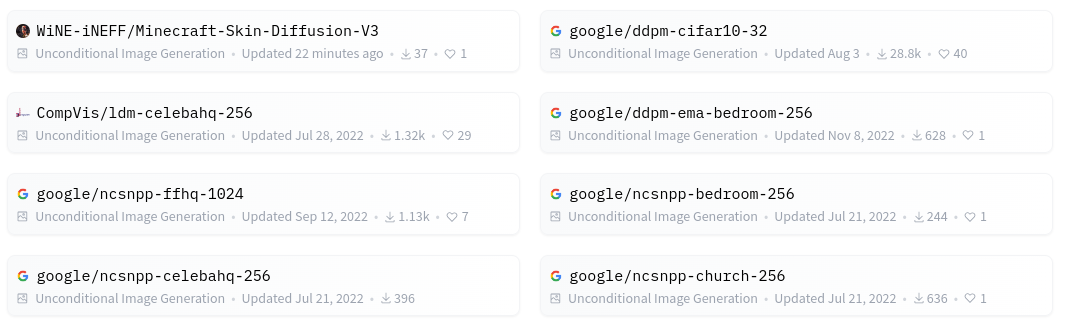

You can substitute the ``model_name`` value in the cell below with any of these model names, like for example ``google/ddpm-cifar10-32`` or ``WiNE-iNEFF/Minecraft-Skin-Diffusion-V3``:

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/mikel/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/mikel/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/1000 [00:00<?, ?it/s]

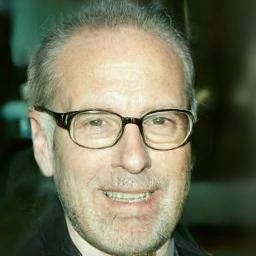

In [5]:
# Celebrity image generation pipeline
# If we change the seed, a different image will be created
rand_gen = torch.manual_seed(12418351)

model_name = 'google/ddpm-celebahq-256'

model = DiffusionPipeline.from_pretrained(model_name).to(device)
image = model(generator=rand_gen).images[0]
image

While most of them can be used this way, some require some special handling. In that case, the code needed to use them is typically reported in the Model Card that can be accessed by simply clicking on the name of the models in [this](https://huggingface.co/models?pipeline_tag=unconditional-image-generation&library=diffusers&sort=trending) list.

## Text-to-image

This is a class of conditional image generation models. The conditioning happens through text: we provide a text prompt, and the model creates an image following that description.

You can find a list of available text-to-image models [here](https://huggingface.co/models?pipeline_tag=text-to-image&library=diffusers&sort=trending).

For example, here we use the Stable Diffusion XL Turbo (a new version of Stable Diffusion XL optimized for super-fast inference):

In [9]:
# Delete any existing pipeline and/or model
try:
    del pipe, model
except:
    pass

# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

47

In [10]:
pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", 
    torch_dtype=torch.float16, 
    variant="fp16"
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

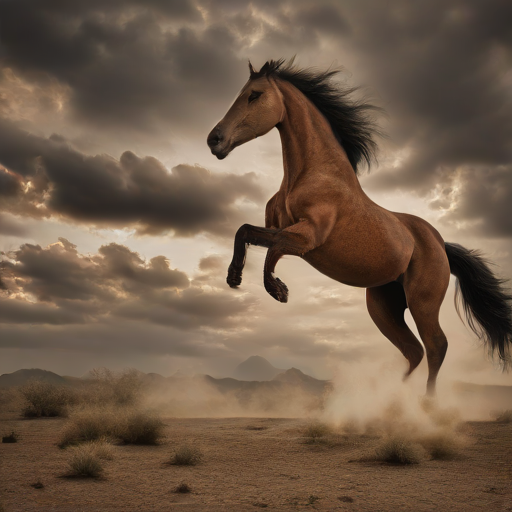

In [11]:
prompt = "A photo of a wild horse jumping in the desert dramatic sky intricate details National Geographic 8k high details"

rand_gen = torch.manual_seed(423122981)

image = pipe(
    prompt=prompt, 
    num_inference_steps=1, # For this model you can use 1, but for normal Stable Diffusion you should use 25 or 50
    guidance_scale=1.0, # For this model 1 is fine, for normal Stable Diffusion you should use 6 or 7, or up to 10 or so
    negative_prompt=["overexposed", "underexposed"], 
    generator=rand_gen
).images[0]

image

In [12]:
from diffusers import DiffusionPipeline, AutoPipelineForText2Image
from diffusers.utils import load_image, make_image_grid

import torch
import gc

In [13]:
# Delete any existing pipeline and/or model
try:
    del pipe, model
except:
    pass

# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

47

This is another example, where we use a nice model by Playground AI that generates artistic images instead of photorealistic ones:

In [14]:
pipe = AutoPipelineForText2Image.from_pretrained(
    "playgroundai/playground-v2-1024px-aesthetic",
    torch_dtype=torch.float16,
    use_safetensors=True,
    add_watermarker=False,
    variant="fp16"
).to(device)

model_index.json:   0%|          | 0.00/680 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/561 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

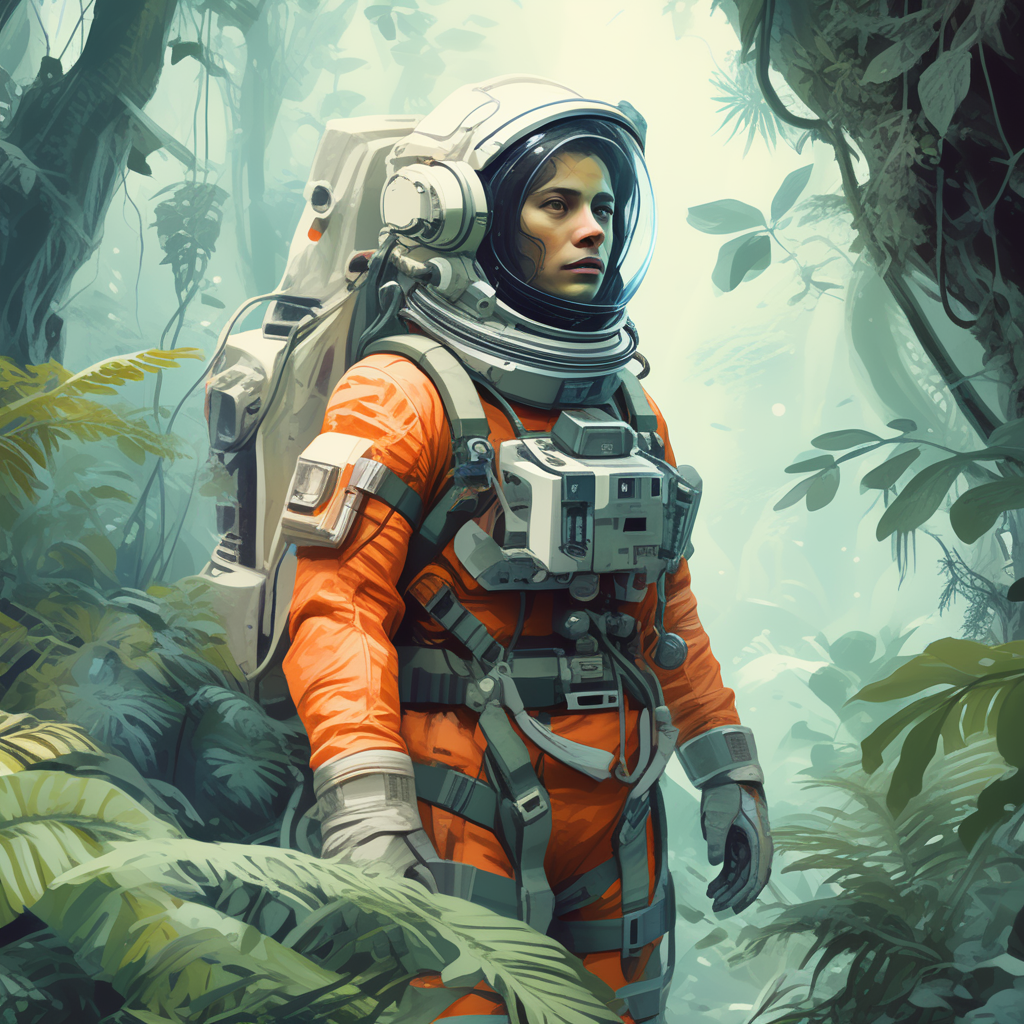

In [15]:
prompt = "A scifi astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
rand_gen = torch.manual_seed(42312981)

image  = pipe(prompt=prompt, guidance_scale=3.0, generator=rand_gen).images[0]
image

## Image-to-image

In the image-to-image task we condition the production of the Diffusion Model through an input image. There are many ways of doing this. Here we look at transforming a barebone sketch of a scene in a beautiful, highly-detailed representation of the same.

Let's start by creating a sketch. We could create that manually, but since we're here, let's use SDXL-Turbo instead.

> NOTE: it is important for the sketch not to be too detailed and complicated. Flat colors typically work best, although this is not an absolute rule.

In [16]:
from diffusers import DiffusionPipeline, AutoPipelineForText2Image
from diffusers.utils import load_image, make_image_grid

import torch
import gc

In [17]:
# Delete any existing pipeline and/or model
try:
    del pipe, model
except:
    pass

# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

47

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

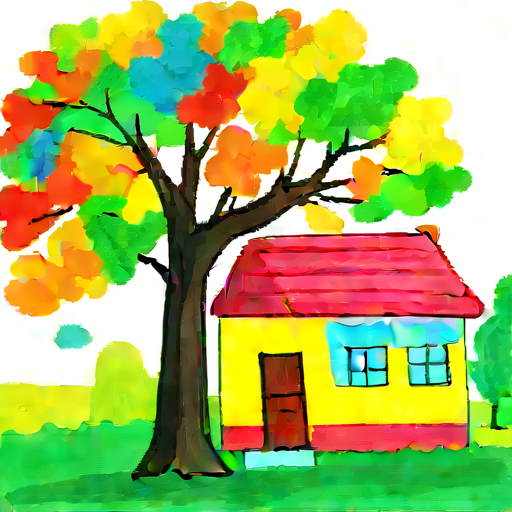

In [18]:
prompt = "A tree and a house, made by a child with 3 colors"
rand_gen = torch.manual_seed(423121)

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", 
    torch_dtype=torch.float16, 
    variant="fp16"
).to(device)

image  = pipe(
    prompt=prompt, 
    num_inference_steps=2,
    guidance_scale=2,
    generator=rand_gen
).images[0]
image

In [19]:
image.save("sketch.png")

In [5]:
from diffusers import DiffusionPipeline, AutoPipelineForText2Image
from diffusers.utils import load_image, make_image_grid
import PIL
import torch
import gc

In [6]:
# Delete any existing pipeline and/or model
try:
    del pipe, model
except:
    pass

# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

100

In [7]:
image = PIL.Image.open("sketch.png")

Now we can use the [Kandinsky](https://github.com/ai-forever/Kandinsky-2) model to generate an image that respects the subjects and their positions in our sketch:

In [8]:
from diffusers import KandinskyV22Img2ImgPipeline, KandinskyPriorPipeline

prior_pipeline = KandinskyPriorPipeline.from_pretrained("kandinsky-community/kandinsky-2-2-prior", torch_dtype=torch.float16, use_safetensors=True).to(device)
pipeline = KandinskyV22Img2ImgPipeline.from_pretrained("kandinsky-community/kandinsky-2-2-decoder", torch_dtype=torch.float16, use_safetensors=True).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

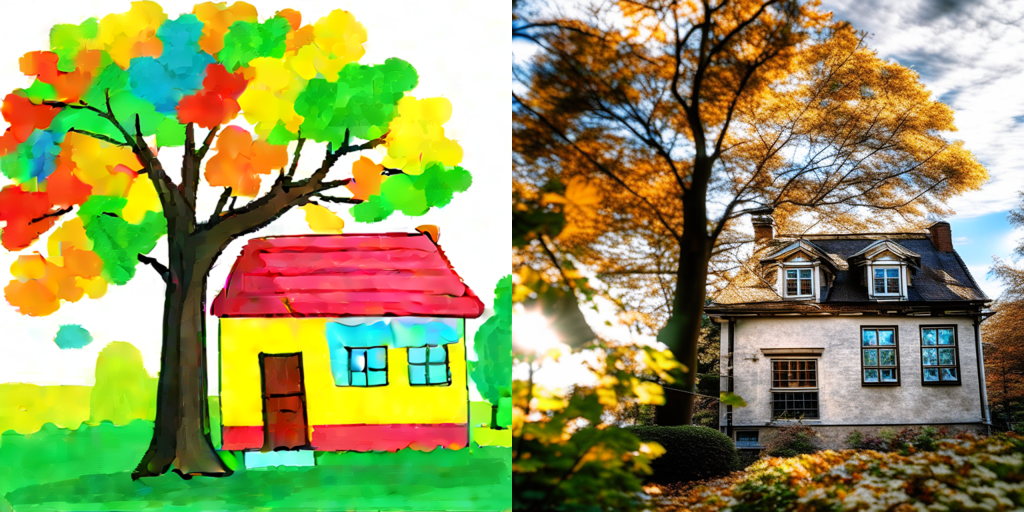

In [9]:
import numpy as np

original_image = image.copy().resize((768, 768))

prompt = "A photograph of a house in the fall, high details, broad daylight"
negative_prompt = "low quality, bad quality"
    
rand_gen = torch.manual_seed(67806801)
image_embeds, negative_image_embeds = prior_pipeline(prompt, negative_prompt, generator=rand_gen).to_tuple()

new_image = pipeline(
    image=original_image, 
    image_embeds=image_embeds, 
    negative_image_embeds=negative_image_embeds, 
    height=768, 
    width=768, 
    strength=0.35,
    generator=rand_gen
).images[0]
fig = make_image_grid([original_image.resize((512, 512)), new_image.resize((512, 512))], rows=1, cols=2)
fig

## Inpainting

Diffusion models can also be used to do inpainting, which means filling regions of an image according to a prompt (or just according to the sourroundings of the hole to fill).

Typically, we start from an image and a mask. The mask indicates the pixels to be inpainted, i.e., removed from the original image and filled with new content generated by the model.

In [1]:
from diffusers import DiffusionPipeline, AutoPipelineForText2Image
from diffusers.utils import load_image, make_image_grid

import torch
import gc

In [2]:
# Delete any existing pipeline and/or model
try:
    del pipe, model, pipeline, prior_pipeline
except:
    pass

# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

100

In [3]:
import torch
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

# Select GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pipeline = AutoPipelineForInpainting.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16
)
pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [4]:
init_image = load_image("monalisa.png").resize((512, 512))
mask_image = load_image("monalisa_mask.png").resize((512, 512))

In [5]:
# To avoid OOM errors
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

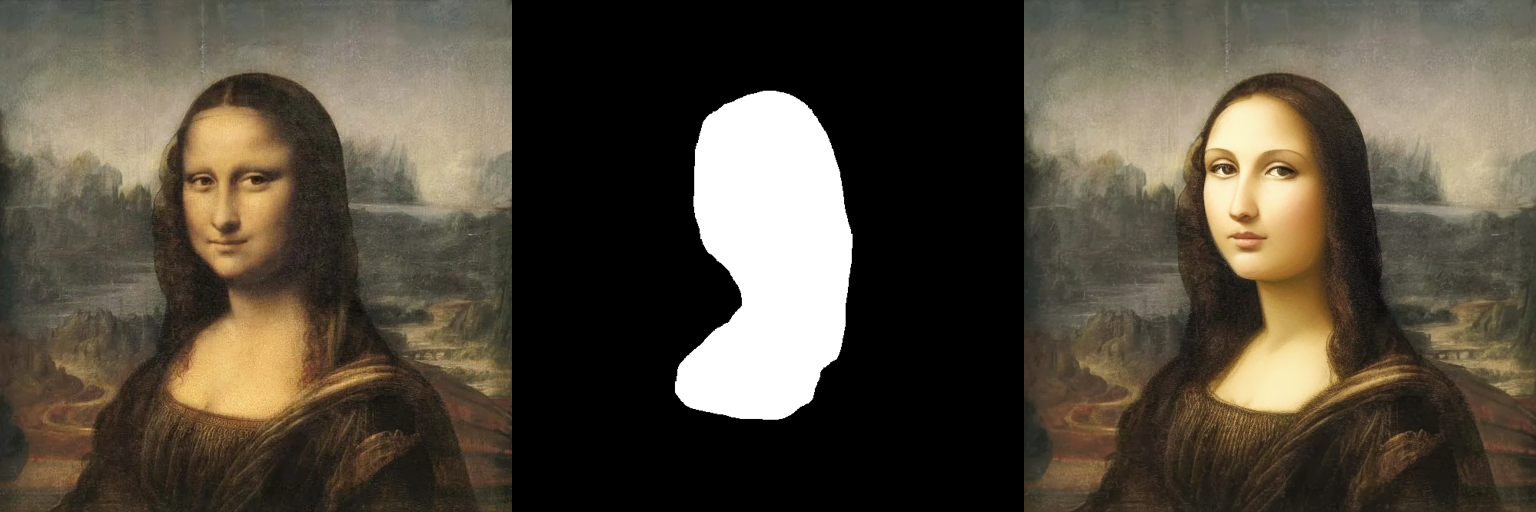

In [6]:
import matplotlib.pyplot as plt

prompt = "oil painting of a woman, sfumato, renaissance, low details, Da Vinci"
negative_prompt = "bad anatomy, deformed, ugly, disfigured"

rand_gen = torch.manual_seed(74294536)
image = pipeline(prompt=prompt, negative_prompt=negative_prompt, image=init_image, mask_image=mask_image, generator=rand_gen, guidance_scale=1.5).images[0]
fig = make_image_grid([init_image, mask_image, image], rows=1, cols=3)
fig

## Beyond images

Diffusion models can also be used for video generation. At the moment of the writing, this field is still in its infancy, but it is progressing fast so keep an eye on the available models as there might be much better ones by the time you are reading this.

The list of available model for text-to-video is available [here](https://huggingface.co/models?pipeline_tag=text-to-video&library=diffusers&sort=trending)

In [ ]:
from IPython.display import Video

import numpy as np
import torch
import gc

# Select GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# Delete any existing pipeline and/or model
# If it doesnt work, restart kernel
try:
    del pipe, model
except:
    pass

# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

100

In [18]:
pipe = DiffusionPipeline.from_pretrained("damo-vilab/text-to-video-ms-1.7b", torch_dtype=torch.float16, variant="fp16").to(device)

prompt = "Earth sphere from space"

rand_gen = torch.manual_seed(42312981)
frames = pipe(prompt, generator=rand_gen).frames[0]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
def get_video(frames, filename, fps=8):
    import numpy as np
    import imageio
    with imageio.get_writer(filename, fps=fps) as writer:
        for image in frames:
            arr = np.asarray(image)
            if arr.ndim == 2:  # grayscale
                arr = np.stack([arr]*3, axis=-1)
            if arr.dtype == np.float32 or arr.max() <= 1.0:
                arr = (arr * 255).clip(0, 255).astype(np.uint8)
            writer.append_data(arr)
    return filename

In [20]:
Video(get_video(frames, "earth.mp4"))

We can also generate a video starting from an image. For example, let's consider the following image (which was generated with Stable Diffusion XL and then [outpainted](https://openai.com/blog/dall-e-introducing-outpainting) using DALLE-2):

<div>
<img src="in_the_desert_outpaint.png" width="500"/>
</div>

> **PLEASE RESTART NOW** to free GPU memory, then continue on from the next cell

In [5]:
import torch
import gc

from diffusers import StableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video
from IPython.display import Video

In [6]:
# Delete any existing pipeline and/or model
try:
    del pipe, model
except:
    pass

# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

100

In [7]:
pipe = StableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=torch.float16, variant="fp16"
).to(device)
# These two settings lower the VRAM usage
pipe.enable_model_cpu_offload()
# pipe.unet.enable_forward_chunking()

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
# Load the conditioning image
image = load_image("in_the_desert_outpaint.png")
image = image.resize((1024, 576))

In [ ]:
generator = torch.manual_seed(999)
res = pipe(
    image, 
    decode_chunk_size=2, 
    generator=generator, 
    num_inference_steps=15, 
    num_videos_per_prompt=1
)

In [24]:
Video(get_video(res.frames[0], "horse2.mp4"))

Overall the animation looks a bit off: the appearance of the legs can definitely be improved, although the overall motion seems correct. Let's try with a different object which has less parts:

<div>
<img src="xwing.jpeg" width="500"/>
</div>

In [25]:
image = load_image("xwing.jpeg")
image = image.resize((1024, 576))

generator = torch.manual_seed(999)
res = pipe(
    image, 
    decode_chunk_size=2, 
    generator=generator, 
    num_inference_steps=25, 
    num_videos_per_prompt=1
)

100% 25/25 [00:43<00:00,  1.73s/it]


In [26]:
Video(get_video(res.frames[0], "xwing.mp4"))

The animation is definitely more realistic here, but still there's a lot to be desired. However, feel free to try other images and prompts and see what you get!